In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install tensorflow-addons
! pip install transformers
!pip install evaluate seqeval



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 6.9 MB/s eta 0:00:00
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16161 sha256=f2e6a4ff7babde2eae2cc416845b31c8f0ff00a129fd75d1e09f2ca891e9f813
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2a

In [ ]:
import spacy
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import ast
import tensorflow as tf
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Input,Bidirectional,LSTM,Embedding, Masking, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D
import tensorflow_addons as tfa
from tensorflow.keras.layers import TimeDistributed
from transformers import TFBertForTokenClassification, BertTokenizer
from transformers import create_optimizer
from transformers import AutoTokenizer
from transformers import DataCollatorForTokenClassification
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer
import evaluate
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [ ]:
# Set seaborn style
sns.set(style="whitegrid")

In [ ]:
# data loader function
def loading_data(data_path):

    data = pd.read_csv(data_path)

    data.dropna(inplace=True)
    print("Number of rows : ",data.shape[0]," and the number of columns : ",data.shape[1])

    return data

In [ ]:
#/content/ner.csv
data_path = 'https://drive.usercontent.google.com/download?id=1tYliwSRKUqnlouCvt8DaxtptmwyEEKyw&export=download&authuser=1&confirm=t&uuid=5dd73343-30ee-46f2-a2a8-299e63f3622d&at=APZUnTWf5NPQLuxJZ_X5706tSkt0:1721428460455'
data = loading_data(data_path)


Number of rows :  47959  and the number of columns :  4


In [ ]:
# showing a sample of the data
data.sample(5).sample(5).style.set_properties(**{'background-color': '#f9f9f9', 'color': '#4CAF50', 'font-weight': 'bold'})

,Sentence #,Sentence,POS,Tag
5957,Sentence: 5958,He said Mr. Blair did not have a lawyer present and was treated as a witness rather than a suspect .,"['PRP', 'VBD', 'NNP', 'NNP', 'VBD', 'RB', 'VB', 'DT', 'NN', 'NN', 'CC', 'VBD', 'VBN', 'IN', 'DT', 'NN', 'RB', 'IN', 'DT', 'NN', '.']","['O', 'O', 'B-per', 'I-per', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']"
22365,Sentence: 22366,"Meanwhile , insurgent attacks continue in Iraq .","['RB', ',', 'JJ', 'NNS', 'VBP', 'IN', 'NNP', '.']","['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O']"
9132,Sentence: 9133,"Caracas airport official Jose Cabello denies this , saying the group made no attempt to contact Venezuelan authorities .","['NNP', 'NN', 'NN', 'NNP', 'NNP', 'VBZ', 'DT', ',', 'VBG', 'DT', 'NN', 'VBD', 'DT', 'NN', 'TO', 'VB', 'JJ', 'NNS', '.']","['B-geo', 'O', 'O', 'B-per', 'I-per', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O']"
32690,Sentence: 32691,But Tokyo now says it would consider a Council presidential statement instead .,"['CC', 'NNP', 'RB', 'VBZ', 'PRP', 'MD', 'VB', 'DT', 'NNP', 'JJ', 'NN', 'RB', '.']","['O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'O', 'B-org', 'O', 'O', 'O', 'O']"
17680,Sentence: 17681,"Ms. Jean immigrated to Canada 's French-speaking Quebec province as a child , after her parents fled Haiti to escape dictatorial rule .","['NNP', 'NNP', 'VBD', 'TO', 'NNP', 'POS', 'JJ', 'NNP', 'NN', 'IN', 'DT', 'NN', ',', 'IN', 'PRP$', 'NNS', 'VBD', 'NNP', 'TO', 'VB', 'JJ', 'NN', '.']","['B-per', 'I-per', 'O', 'O', 'B-geo', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O']"


In [ ]:
#data preprocessing function
def preprocess_data(data):
    for i in range(len(data)):
        pos = ast.literal_eval(data.loc[i, 'POS'])
        tags = ast.literal_eval(data.loc[i, 'Tag'])
        data.loc[i, 'POS'] = [str(word) for word in pos]
        data.loc[i, 'Tag'] = [str(word.upper()) for word in tags]
    return data

In [ ]:
# preprocessing the data
data = preprocess_data(data)


In [ ]:
#showing a sample of the data after the preprocessing
data.sample(5).style.set_properties(**{'background-color': '#f9f9f9', 'color': '#4CAF50', 'font-weight': 'bold'})


,Sentence #,Sentence,POS,Tag
10209,Sentence: 10210,The United States and Israel have agreed to work together on developing a new missile defense system that would counter both long-range ballistic missiles as well as short-range rockets .,"['DT', 'NNP', 'NNPS', 'CC', 'NNP', 'VBP', 'VBN', 'TO', 'VB', 'RB', 'IN', 'VBG', 'DT', 'JJ', 'NN', 'NN', 'NN', 'WDT', 'MD', 'VB', 'DT', 'JJ', 'JJ', 'NNS', 'RB', 'RB', 'IN', 'JJ', 'NNS', '.']","['O', 'B-GEO', 'I-GEO', 'O', 'B-GEO', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']"
46149,Sentence: 46150,He was later cleared by the Colombian legislature .,"['PRP', 'VBD', 'RB', 'VBN', 'IN', 'DT', 'JJ', 'NN', '.']","['O', 'O', 'O', 'O', 'O', 'O', 'B-GPE', 'O', 'O']"
23296,Sentence: 23297,"The wrestler 's coach , Zhang Hua , also received a permanent ban .","['DT', 'NN', 'POS', 'NN', ',', 'NNP', 'NNP', ',', 'RB', 'VBD', 'DT', 'JJ', 'NN', '.']","['O', 'O', 'O', 'O', 'O', 'B-PER', 'I-PER', 'O', 'O', 'O', 'O', 'O', 'O', 'O']"
45999,Sentence: 46000,French tennis great Mary Pierce has withdrawn from the ASB Classic women 's tennis tournament in New Zealand next week for undisclosed medical reasons .,"['JJ', 'NN', 'JJ', 'NNP', 'NNP', 'VBZ', 'VBN', 'IN', 'DT', 'NNP', 'NNP', 'NNS', 'POS', 'NN', 'NN', 'IN', 'NNP', 'NNP', 'JJ', 'NN', 'IN', 'JJ', 'JJ', 'NNS', '.']","['B-GPE', 'O', 'O', 'B-PER', 'I-PER', 'O', 'O', 'O', 'O', 'B-ORG', 'I-ORG', 'O', 'O', 'O', 'O', 'O', 'B-GEO', 'I-GEO', 'O', 'O', 'O', 'O', 'O', 'O', 'O']"
29992,Sentence: 29993,"Last month , 24 fires in southern California burned through nearly 2,00,000 hectares and destroyed 2,000 homes .","['JJ', 'NN', ',', 'CD', 'NNS', 'IN', 'JJ', 'NNP', 'VBD', 'IN', 'RB', 'CD', 'NNS', 'CC', 'VBD', 'CD', 'NNS', '.']","['O', 'O', 'O', 'O', 'O', 'O', 'B-GEO', 'I-GEO', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']"


In [ ]:
#forming the final dataset
df_final = data[['Sentence','Tag']]


In [ ]:
#showing a sample of the final dataset
df_final

,Sentence,Tag
0,Thousands of demonstrators have marched throug...,"[O, O, O, O, O, O, B-GEO, O, O, O, O, O, B-GEO..."
1,Families of soldiers killed in the conflict jo...,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
2,They marched from the Houses of Parliament to ...,"[O, O, O, O, O, O, O, O, O, O, O, B-GEO, I-GEO..."
3,"Police put the number of marchers at 10,000 wh...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]"
4,The protest comes on the eve of the annual con...,"[O, O, O, O, O, O, O, O, O, O, O, B-GEO, O, O,..."
...,...,...
47954,Indian border security forces are accusing the...,"[B-GPE, O, O, O, O, O, O, B-GPE, O, O, O, O, O..."
47955,Indian officials said no one was injured in Sa...,"[B-GPE, O, O, O, O, O, O, O, B-TIM, O, O, O, O..."
47956,Two more landed in fields belonging to a nearb...,"[O, O, O, O, O, O, O, O, O, O, O]"
47957,They say not all of the rockets exploded upon ...,"[O, O, O, O, O, O, O, O, O, O, O]"


In [ ]:
#splitting the dataset for train and test
df_train,df_test = train_test_split(df_final,test_size=0.2,random_state=42)
len(df_train),len(df_test)

(38367, 9592)

In [ ]:
#tokenizing the data
train_targets = list(df_train.Tag.values)
test_targets = list(df_test.Tag.values)

tokenizer = Tokenizer(lower=False,oov_token="UNK")
tokenizer.fit_on_texts(df_train['Sentence'])

train_inputs = tokenizer.texts_to_sequences(df_train['Sentence'])
test_inputs = tokenizer.texts_to_sequences(df_test['Sentence'])

In [ ]:
word2idx = tokenizer.word_index
V = len(word2idx) # Vocab size
print("Found %s unique tokens "%V)

Found 28761 unique tokens 


In [ ]:
# showing both unique train and test tags
train_tags = set([val for sublist in train_targets for val in sublist])
test_tags = set([val for sublist in test_targets for val in sublist])

print("Unique NER tags in train set: ",train_tags)
print("Unique NER tags in test set: ",test_tags)

Unique NER tags in train set:  {'I-GEO', 'B-GEO', 'I-EVE', 'B-ART', 'B-EVE', 'B-NAT', 'I-ART', 'B-ORG', 'B-TIM', 'I-GPE', 'I-TIM', 'B-GPE', 'I-NAT', 'O', 'B-PER', 'I-ORG', 'I-PER'}
Unique NER tags in test set:  {'I-GEO', 'B-GEO', 'I-EVE', 'B-ART', 'B-EVE', 'B-NAT', 'I-ART', 'B-ORG', 'B-TIM', 'I-GPE', 'I-TIM', 'B-GPE', 'I-NAT', 'O', 'B-PER', 'I-ORG', 'I-PER'}


In [ ]:
tag_tokenizer = Tokenizer()
tag_tokenizer.fit_on_texts(train_targets)
train_tgt_int = tag_tokenizer.texts_to_sequences(train_targets)
test_tgt_int = tag_tokenizer.texts_to_sequences(test_targets)

In [ ]:
# Max length
max_length_train = max(len(sent) for sent in train_inputs)
max_length_test = max(len(sent) for sent in test_inputs)
max_length = max(max_length_train,max_length_test)

# Pad input sequences
train_inputs_final = pad_sequences(train_inputs,maxlen=max_length,padding="post")
print("Shape of train inputs: ",train_inputs_final.shape)

test_inputs_final = pad_sequences(test_inputs,maxlen=max_length,padding="post")
print("Shape of test inputs: ",test_inputs_final.shape)

train_targets_final = pad_sequences(train_tgt_int,maxlen=max_length,padding="post")
print("Shape of train targets: ",train_targets_final.shape)

test_targets_final = pad_sequences(test_tgt_int,maxlen=max_length,padding="post")
print("Shape of test targets: ",test_targets_final.shape)

Shape of train inputs:  (38367, 89)
Shape of test inputs:  (9592, 89)
Shape of train targets:  (38367, 89)
Shape of test targets:  (9592, 89)


In [ ]:
# Number of classes
K = len(tag_tokenizer.word_index)  +1
K

18

# **LSTM model**

In [ ]:
# Parameters
max_length = 89
V = 10000
K = 18
vector_size = 16

In [ ]:
# Input layer
i = Input(shape=(max_length,))
# Embedding layer
x = Embedding(input_dim=V+1, output_dim=vector_size, mask_zero=True)(i)
x = Masking()(x)  # Masking layer to handle variable length sequences
x = Bidirectional(LSTM(32, return_sequences=True))(x)
x = Dense(K)(x)

In [ ]:
# Model definition
model = Model(i, x)

In [ ]:
model.summary()


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 89)]              0         
                                                                 
 embedding_2 (Embedding)     (None, 89, 16)            160016    
                                                                 
 masking_2 (Masking)         (None, 89, 16)            0         
                                                                 
 bidirectional_2 (Bidirecti  (None, 89, 64)            12544     
 onal)                                                           
                                                                 
 dense_2 (Dense)             (None, 89, 18)            1170      
                                                                 
Total params: 173730 (678.63 KB)
Trainable params: 173730 (678.63 KB)
Non-trainable params: 0 (0.00 Byte)
___________________

In [ ]:
# Compile the model
model.compile(
    optimizer="adam",
    loss=SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [ ]:
print(f"train_inputs_final shape: {train_inputs_final.shape}")
print(f"train_targets_final shape: {train_targets_final.shape}")
print(f"test_inputs_final shape: {test_inputs_final.shape}")
print(f"test_targets_final shape: {test_targets_final.shape}")

train_inputs_final shape: (38367, 89)
train_targets_final shape: (38367, 89)
test_inputs_final shape: (9592, 89)
test_targets_final shape: (9592, 89)


In [ ]:
# Define callbacks
checkpoint = ModelCheckpoint("/content/drive/MyDrive/widebot/model_checkpoint.keras", monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)



In [ ]:
# Train the model with callbacks
history = model.fit(
    train_inputs_final,
    train_targets_final,
    epochs=50,
    validation_data=(test_inputs_final, test_targets_final),
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/50
1199/1199 [==============================] - ETA: 0s - loss: 0.2666 - accuracy: 0.9413
Epoch 1: val_loss improved from inf to 0.15881, saving model to /content/drive/MyDrive/widebot/model_checkpoint.keras
1199/1199 [==============================] - 159s 123ms/step - loss: 0.2666 - accuracy: 0.9413 - val_loss: 0.1588 - val_accuracy: 0.9553
Epoch 2/50
1199/1199 [==============================] - ETA: 0s - loss: 0.1399 - accuracy: 0.9588
Epoch 2: val_loss improved from 0.15881 to 0.12351, saving model to /content/drive/MyDrive/widebot/model_checkpoint.keras
1199/1199 [==============================] - 137s 115ms/step - loss: 0.1399 - accuracy: 0.9588 - val_loss: 0.1235 - val_accuracy: 0.9626
Epoch 3/50
1199/1199 [==============================] - ETA: 0s - loss: 0.1089 - accuracy: 0.9656
Epoch 3: val_loss improved from 0.12351 to 0.10562, saving model to /content/drive/MyDrive/widebot/model_checkpoint.keras
1199/1199 [==============================] - 139s 116ms/step - loss: 0

In [ ]:
# Save the model to a file using tf.keras.models.save_model()
tf.keras.models.save_model(model, "/content/drive/MyDrive/widebot/ner_model.h5")

<ipython-input-50-356018157e02>:2: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model, "/content/drive/MyDrive/widebot/ner_model.h5")


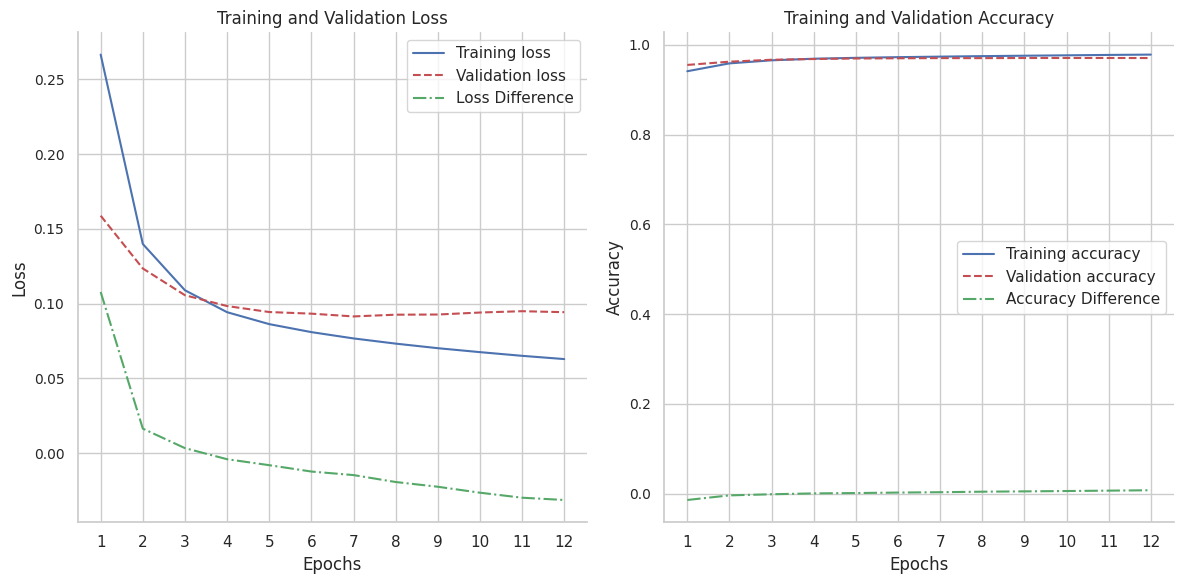

In [ ]:
sns.set(style="whitegrid")

# Get training history
train_loss = history.history['loss']
train_acc = history.history['accuracy']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']
epochs = range(1, len(train_loss) + 1)

# Calculate differences
loss_diff = [train_loss[i] - val_loss[i] for i in range(len(train_loss))]
acc_diff = [train_acc[i] - val_acc[i] for i in range(len(train_acc))]

# Plot training and validation loss in subplots
plt.figure(figsize=(12, 6))

# Subplot 1: Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='Training loss')
plt.plot(epochs, val_loss, 'r--', label='Validation loss')
plt.plot(epochs, loss_diff, 'g-.', label='Loss Difference')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xticks(epochs)
plt.yticks(fontsize=10)

# Subplot 2: Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'b-', label='Training accuracy')
plt.plot(epochs, val_acc, 'r--', label='Validation accuracy')
plt.plot(epochs, acc_diff, 'g-.', label='Accuracy Difference')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xticks(epochs)
plt.yticks(fontsize=10)

plt.tight_layout()

# Show plot
plt.show()

In [ ]:
unique_tags = ['O', 'B-GEO', 'B-GPE', 'B-ORG', 'B-PER', 'B-ART', 'B-EVE', 'B-NAT', 'B-TIM',
               'I-GEO', 'I-GPE', 'I-ORG', 'I-PER', 'I-ART', 'I-EVE', 'I-NAT', 'I-TIM', 'PAD']  # Added 'PAD' tag

In [ ]:
# Define your sample sentence
sentence = "Polish Prime Minister Jaroslaw Kaczynski has voiced support for the deployment of 10 U.S. missile interceptors in Poland and guidance technology in the Czech Republic."

# Preprocess the sentence
tokenized_sentence = tokenizer.texts_to_sequences([sentence])
padded_sentence = pad_sequences(tokenized_sentence, maxlen=max_length, padding="post")

# Function to validate and clip inputs
def validate_inputs(inputs, max_value):
    if np.max(inputs) > max_value:
        print(f"Warning: Found input values greater than {max_value}. Clipping values.")
        inputs = np.clip(inputs, 0, max_value)
    return inputs

# Validate tokenized and padded input
padded_sentence = validate_inputs(padded_sentence, V)

# Make predictions
predictions = model.predict(padded_sentence)
prediction_ner = np.argmax(predictions, axis=-1)

# Check the shapes and classes
print(f"Shape of predictions array: {predictions.shape}")
print(f"Predicted NER tags: {prediction_ner}")

1/1 [==============================] - 0s 116ms/step
Shape of predictions array: (1, 89, 18)
Predicted NER tags: [[8 6 1 5 5 1 1 1 1 1 1 1 1 2 1 1 1 2 1 1 1 1 1 1 8 1 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


In [ ]:
# Ensuring the number of classes matches the length of unique_tags
assert len(unique_tags) == predictions.shape[-1], "Number of classes does not match the length of unique tags"

# Get the predicted tags
predicted_tags = [[unique_tags[idx] for idx in sentence] for sentence in prediction_ner]

# Example sentence and its predictions
example_sentence = sentence.split()  # Use sentence tokens instead of dummy 'tokens'
example_predictions = predicted_tags[0]

# Displaying the tokens with their predicted tags
from tabulate import tabulate
table = [[token, tag] for token, tag in zip(example_sentence, example_predictions)]
print(tabulate(table, headers=["Token", "Predicted NER Tag"], tablefmt="grid"))

+--------------+---------------------+
| Token        | Predicted NER Tag   |
+==============+=====================+
| Polish       | B-TIM               |
+--------------+---------------------+
| Prime        | B-EVE               |
+--------------+---------------------+
| Minister     | B-GEO               |
+--------------+---------------------+
| Jaroslaw     | B-ART               |
+--------------+---------------------+
| Kaczynski    | B-ART               |
+--------------+---------------------+
| has          | B-GEO               |
+--------------+---------------------+
| voiced       | B-GEO               |
+--------------+---------------------+
| support      | B-GEO               |
+--------------+---------------------+
| for          | B-GEO               |
+--------------+---------------------+
| the          | B-GEO               |
+--------------+---------------------+
| deployment   | B-GEO               |
+--------------+---------------------+
| of           | B-GEO   

<ipython-input-58-5f9034ce84b1>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=unique_tags, y=predictions[0][0], palette='coolwarm', edgecolor='black')


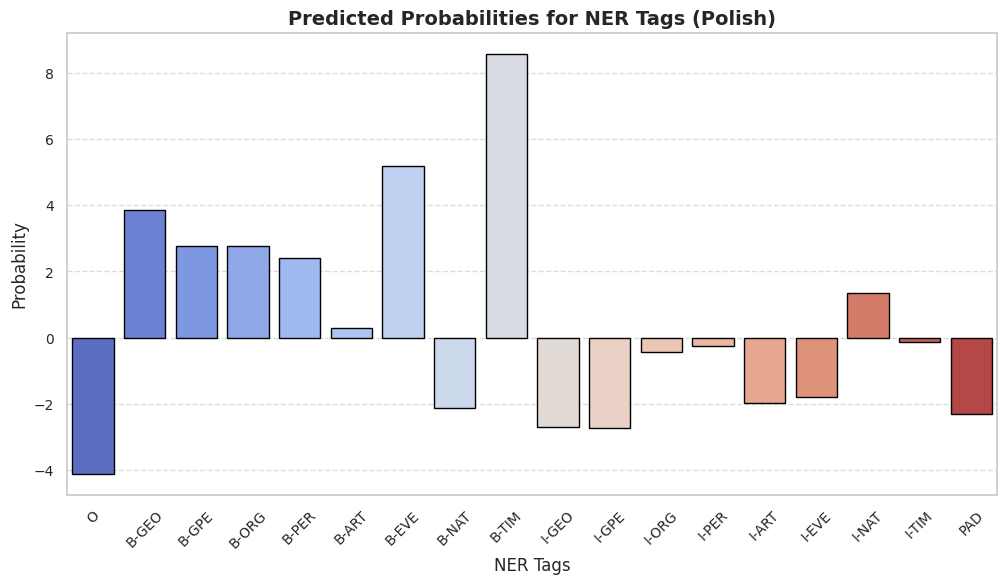

<Figure size 2000x1000 with 0 Axes>

In [ ]:
# Bar Plot for the first token
plt.figure(figsize=(12, 6))
sns.barplot(x=unique_tags, y=predictions[0][0], palette='coolwarm', edgecolor='black')
plt.title(f'Predicted Probabilities for NER Tags ({example_sentence[0]})', fontsize=14, weight='bold')
plt.xlabel('NER Tags', fontsize=12)
plt.ylabel('Probability', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

plt.figure(figsize=(20, 10))


plt.show()

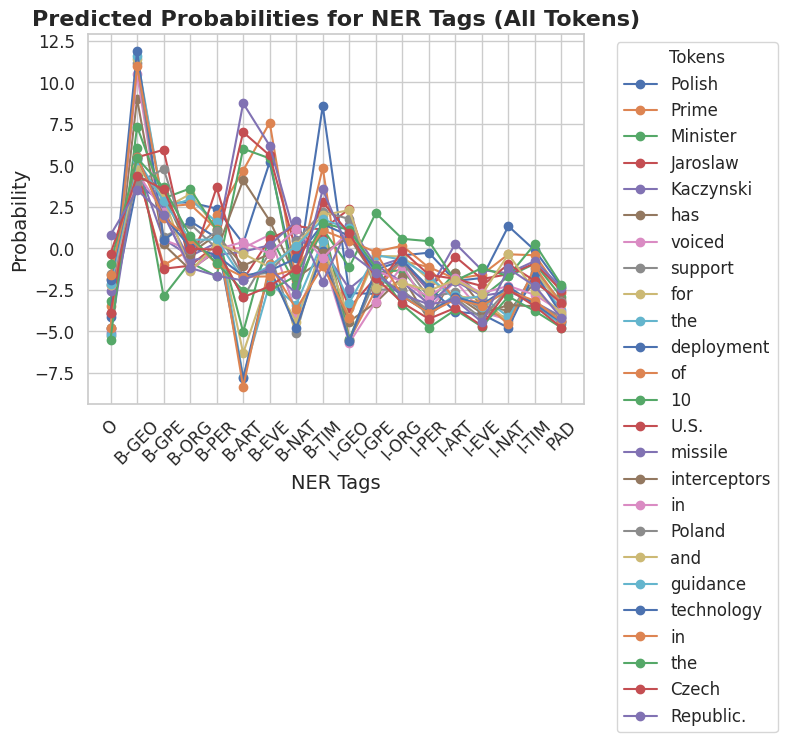

In [ ]:
# Plotting line plots for each token
for i, token in enumerate(example_sentence):
    plt.plot(unique_tags, predictions[0][i], label=token, marker='o')

plt.title('Predicted Probabilities for NER Tags (All Tokens)', fontsize=16, weight='bold')
plt.xlabel('NER Tags', fontsize=14)
plt.ylabel('Probability', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Tokens', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
plt.grid(True)
plt.show()




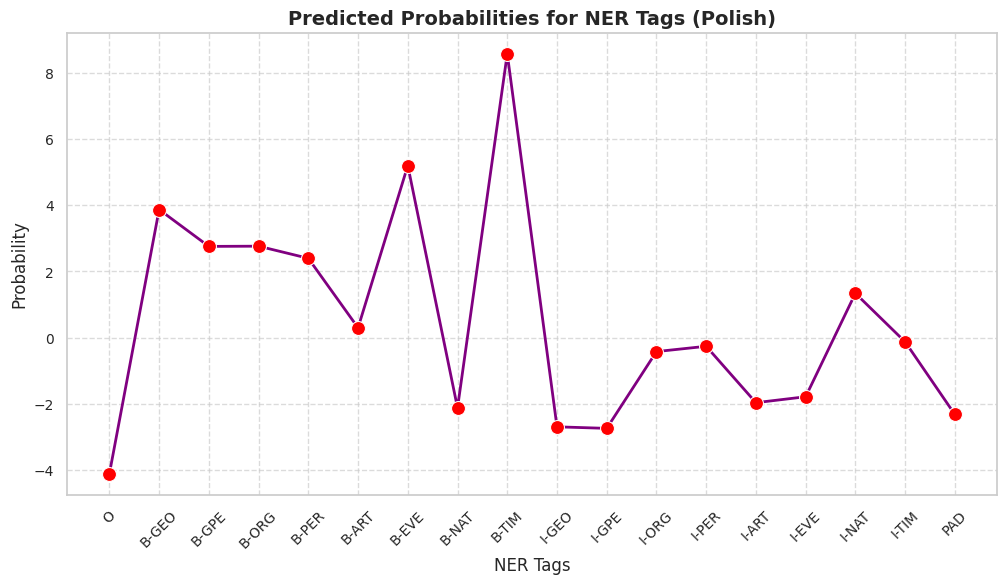

In [ ]:
# Line Plot for the first token
plt.figure(figsize=(12, 6))
sns.lineplot(x=unique_tags, y=predictions[0][0], marker='o', linestyle='-', color='purple', markerfacecolor='red', markersize=10, lw=2)
plt.title(f'Predicted Probabilities for NER Tags ({example_sentence[0]})', fontsize=14, weight='bold')
plt.xlabel('NER Tags', fontsize=12)
plt.ylabel('Probability', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)

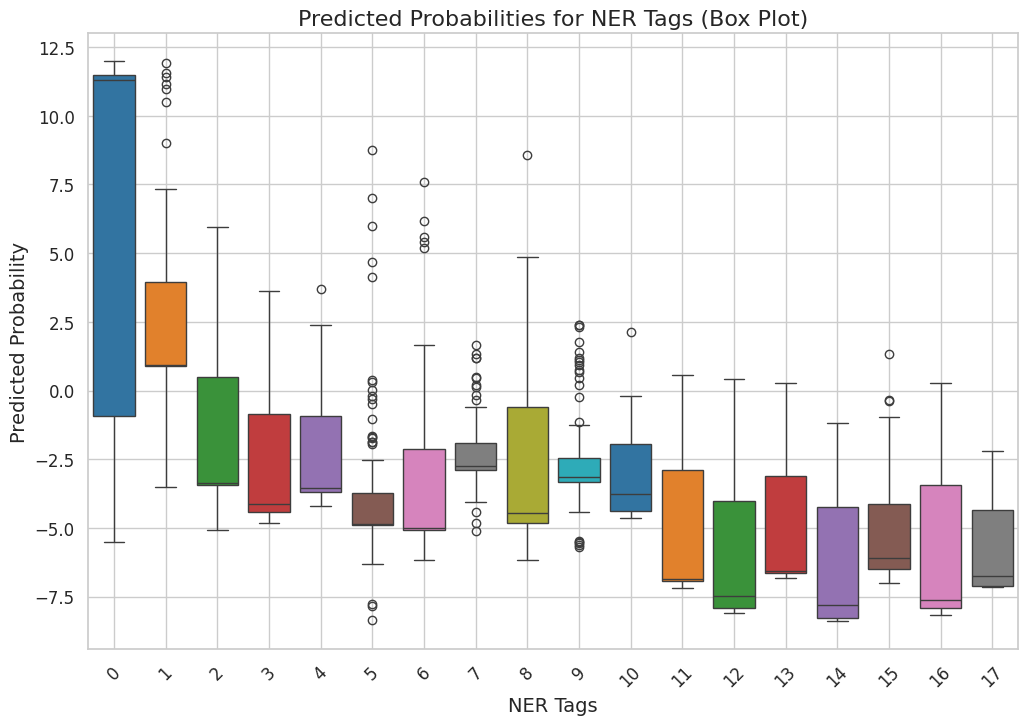

In [ ]:
# Box Plot
plt.figure(figsize=(12, 8))
sns.boxplot(data=predictions[0], palette='tab10')
plt.title('Predicted Probabilities for NER Tags (Box Plot)', fontsize=16)
plt.xlabel('NER Tags', fontsize=14)
plt.ylabel('Predicted Probability', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.show()

In [ ]:
def create_stacked_bilstm_model(max_length, V, vector_size, K):
    i = Input(shape=(max_length,))
    x = Embedding(input_dim=V+1, output_dim=vector_size, mask_zero=True)(i)
    x = Masking()(x)
    x = Bidirectional(LSTM(32, return_sequences=True))(x)
    x = Bidirectional(LSTM(32, return_sequences=True))(x)
    x = Dense(K, activation='softmax')(x)

    model = Model(i, x)
    model.compile(optimizer="adam", loss=SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
    return model

# Create and compile the model
stacked_bilstm_model = create_stacked_bilstm_model(max_length, V, vector_size, K)

In [ ]:
# Train the model
history_stacked_bilstm = stacked_bilstm_model.fit(
    train_inputs_final,
    train_targets_final,
    epochs=50,
    validation_data=(test_inputs_final, test_targets_final),
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1199/1199 [==============================] - ETA: 0s - loss: 0.2583 - accuracy: 0.9437
Epoch 1: val_loss did not improve from 0.09143
1199/1199 [==============================] - 304s 235ms/step - loss: 0.2583 - accuracy: 0.9437 - val_loss: 0.1799 - val_accuracy: 0.9553
Epoch 2/50
1199/1199 [==============================] - ETA: 0s - loss: 0.1473 - accuracy: 0.9579
Epoch 2: val_loss did not improve from 0.09143
1199/1199 [==============================] - 265s 221ms/step - loss: 0.1473 - accuracy: 0.9579 - val_loss: 0.1341 - val_accuracy: 0.9604
Epoch 3/50
1199/1199 [==============================] - ETA: 0s - loss: 0.1091 - accuracy: 0.9661
Epoch 3: val_loss did not improve from 0.09143
1199/1199 [==============================] - 268s 224ms/step - loss: 0.1091 - accuracy: 0.9661 - val_loss: 0.1024 - val_accuracy: 0.9680
Epoch 4/50
1199/1199 [==============================] - ETA: 0s - loss: 0.0882 - accuracy: 0.9708
Epoch 4: val_loss did not improve from 0.09143
1199/1199 [=========

In [ ]:
sns.set(style="whitegrid")

def plot_training_history(history, title):
    # Get training history
    train_loss = history.history['loss']
    train_acc = history.history['accuracy']
    val_loss = history.history['val_loss']
    val_acc = history.history['val_accuracy']
    epochs = range(1, len(train_loss) + 1)

    # Calculate differences
    loss_diff = [train_loss[i] - val_loss[i] for i in range(len(train_loss))]
    acc_diff = [train_acc[i] - val_acc[i] for i in range(len(train_acc))]

    # Plot training and validation loss in subplots
    plt.figure(figsize=(12, 6))

    # Subplot 1: Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, 'b-', label='Training loss')
    plt.plot(epochs, val_loss, 'r--', label='Validation loss')
    plt.plot(epochs, loss_diff, 'g-.', label='Loss Difference')
    plt.title(f'{title} - Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.xticks(epochs)
    plt.yticks(fontsize=10)

    # Subplot 2: Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, 'b-', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r--', label='Validation accuracy')
    plt.plot(epochs, acc_diff, 'g-.', label='Accuracy Difference')
    plt.title(f'{title} - Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.xticks(epochs)
    plt.yticks(fontsize=10)

    plt.tight_layout()
    plt.show()

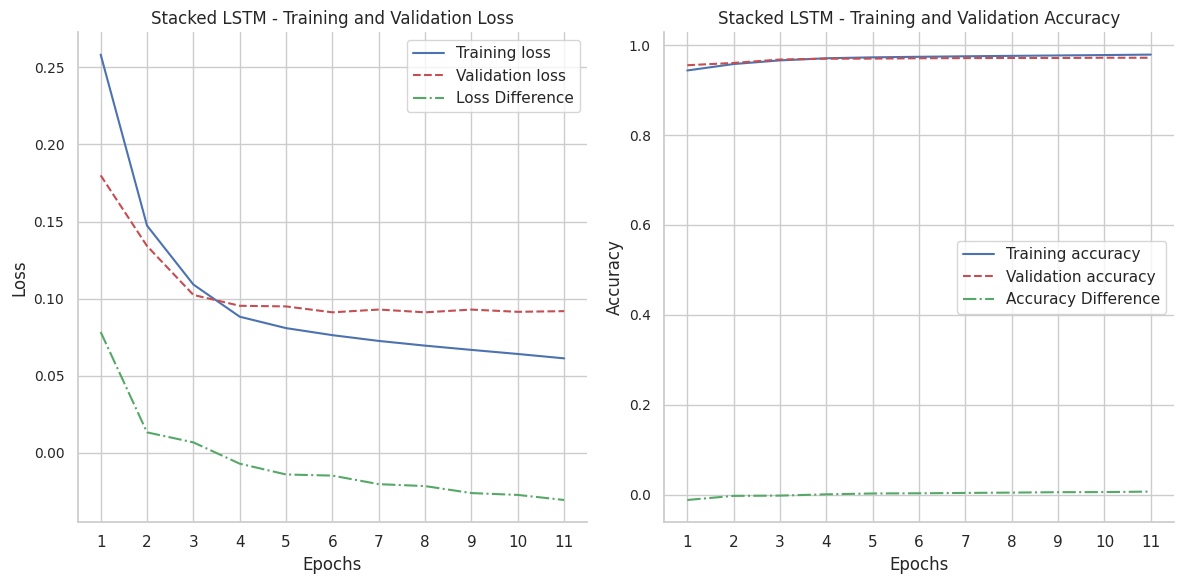

In [ ]:
# Plot for the stacked LSTM model
plot_training_history(history_stacked_bilstm, "Stacked LSTM")

In [ ]:
df_final.head()


,Sentence,Tag
0,Thousands of demonstrators have marched throug...,"[O, O, O, O, O, O, B-GEO, O, O, O, O, O, B-GEO..."
1,Families of soldiers killed in the conflict jo...,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
2,They marched from the Houses of Parliament to ...,"[O, O, O, O, O, O, O, O, O, O, O, B-GEO, I-GEO..."
3,"Police put the number of marchers at 10,000 wh...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]"
4,The protest comes on the eve of the annual con...,"[O, O, O, O, O, O, O, O, O, O, O, B-GEO, O, O,..."


In [ ]:
# Unique labels
labels = [set([val for sublist in df_final['Tag'].values for val in sublist])]

# Label2index
label2index = {"O":0,"B-PER":1,"I-PER":2,"B-GEO":3,"I-GEO":4,"B-ART":5,"I-ART":6,
              "B-GPE":7,"I-GPE":8,"B-EVE":9,"I-EVE":10,"B-NAT":11,"I-NAT":12,"B-ORG":13,
              "I-ORG":14,"B-TIM":15,"I-TIM":16}

index2label = {v:k for k,v in label2index.items()}

In [ ]:
# Create a column with the tokens for each sentence and numeric labels

def create_tokens(text):
    data = [word for word in text.split()]
    return data

def create_num_labels(label):
    num_label = [label2index[text] for text in label]
    return num_label

df_trf = df_final.copy()
df_trf.loc[:,'Tokens'] = df_trf['Sentence'].apply(lambda x: create_tokens(x))
df_trf.loc[:,'NER_Tags'] = df_trf['Tag'].apply(lambda label:create_num_labels(label))

# Remove rows with unequal # tokens and # tags
index_labels = []
for i in range(len(df_trf)):
    if len(df_trf['Tokens'][i]) != len(df_trf['NER_Tags'][i]):
        print(f"Tokens and tags at index {i} don't match")
        index_labels.append(i)

# Drop rows at index positions in index_labels
for idx in index_labels:
    df_trf.drop(index=idx,inplace=True)

# Reset index
df_trf.reset_index(drop=True,inplace=True)

# Select relevant columns only
df_trf = df_trf[['Tokens','NER_Tags']]
df_trf.head()

Tokens and tags at index 76 don't match
Tokens and tags at index 10051 don't match
Tokens and tags at index 19817 don't match
Tokens and tags at index 47591 don't match


,Tokens,NER_Tags
0,"[Thousands, of, demonstrators, have, marched, ...","[0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 3, 0, 0, ..."
1,"[Families, of, soldiers, killed, in, the, conf...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,"[They, marched, from, the, Houses, of, Parliam...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 0]"
3,"[Police, put, the, number, of, marchers, at, 1...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
4,"[The, protest, comes, on, the, eve, of, the, a...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 13,..."


In [ ]:
len(df_trf)


47955

In [ ]:
# Converting the dataframe to a dictionary for better conversion
df_dict = df_trf.to_dict('list')

In [ ]:
from datasets import Dataset, load_dataset
raw_dataset = Dataset.from_dict(df_dict)
raw_dataset

Dataset({
    features: ['Tokens', 'NER_Tags'],
    num_rows: 47955
})

In [ ]:
raw_dataset[0]


{'Tokens': ['Thousands',
  'of',
  'demonstrators',
  'have',
  'marched',
  'through',
  'London',
  'to',
  'protest',
  'the',
  'war',
  'in',
  'Iraq',
  'and',
  'demand',
  'the',
  'withdrawal',
  'of',
  'British',
  'troops',
  'from',
  'that',
  'country',
  '.'],
 'NER_Tags': [0,
  0,
  0,
  0,
  0,
  0,
  3,
  0,
  0,
  0,
  0,
  0,
  3,
  0,
  0,
  0,
  0,
  0,
  7,
  0,
  0,
  0,
  0,
  0]}

In [ ]:
split = raw_dataset.train_test_split(test_size=0.15,shuffle=True,seed=42)
split

DatasetDict({
    train: Dataset({
        features: ['Tokens', 'NER_Tags'],
        num_rows: 40761
    })
    test: Dataset({
        features: ['Tokens', 'NER_Tags'],
        num_rows: 7194
    })
})

In [ ]:
checkpoint = 'distilbert-base-cased'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/465 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [ ]:
example = split["train"][0]
tokenized_input = tokenizer(example["Tokens"], is_split_into_words=True)
tokens = tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])
tokens

['[CLS]',
 'The',
 'NL',
 '##D',
 'was',
 'founded',
 'in',
 '1988',
 ',',
 'after',
 'the',
 'military',
 'crushed',
 'a',
 'pro',
 '-',
 'democracy',
 'uprising',
 'in',
 'Burma',
 '.',
 '[SEP]']

In [ ]:
label_names = [key for key in label2index.keys()]
label_names

['O',
 'B-PER',
 'I-PER',
 'B-GEO',
 'I-GEO',
 'B-ART',
 'I-ART',
 'B-GPE',
 'I-GPE',
 'B-EVE',
 'I-EVE',
 'B-NAT',
 'I-NAT',
 'B-ORG',
 'I-ORG',
 'B-TIM',
 'I-TIM']

In [ ]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["Tokens"], truncation=True, is_split_into_words=True)

    labels = []
    for i, label in enumerate(examples[f"NER_Tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)  # Map tokens to their respective word.
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:  # Set the special tokens to -100.
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:  # Only label the first token of a given word.
                label_ids.append(label[word_idx])
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx
        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [ ]:
# Apply the preprocessing function over dataset

tokenized_dataset = split.map(tokenize_and_align_labels,batched=True)
tokenized_dataset

Map:   0%|          | 0/40761 [00:00<?, ? examples/s]

Map:   0%|          | 0/7194 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['Tokens', 'NER_Tags', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 40761
    })
    test: Dataset({
        features: ['Tokens', 'NER_Tags', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 7194
    })
})

In [ ]:
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)


In [ ]:
seqeval = evaluate.load("seqeval")

In [ ]:
labels = [label_names[i] for i in example[f"NER_Tags"]]


def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_predictions = [
        [label_names[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_names[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = seqeval.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

In [ ]:
model = AutoModelForTokenClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=17, id2label=index2label, label2id=label2index
)

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
training_args = TrainingArguments(
    output_dir="ner_model",
    learning_rate=2e-5,
    per_device_train_batch_size=9,
    per_device_eval_batch_size=6,
    num_train_epochs=1,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)



In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss
